In [1]:
# Importing required libraries
import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
import numpy as np
import pathlib
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
# Setting up default arguments for saving figures
savefig_args = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.1,
    "transparent": True,
}

# Set figure and Pandas display parameters
mpl.rc("savefig", dpi=300)
sc.set_figure_params(
    dpi_save=150,
    frameon=False,
    vector_friendly=True,
    fontsize=6,
    figsize=(3,3),
    format='pdf',
    transparent=True
)
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 20)
pd.set_option("display.width", 100)

# Define style settings
sns.set_style("ticks")
plt.style.use('../scripts/bursa.mplstyle')

# Define file output configurations
output_dir = "../figures/MB_shared_GEX/"
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)  # Create the directory if it does not exist
output_suffix = ""
output_formats = [".png", ".pdf"]


# configuration:
data_dir = "../../data/annotation"
h5ad = f'{data_dir}/all_sharing.h5ad.gz'
#h5ad = f'{data_dir}/TBd6_sharing.h5ad.gz'
tissue_combo = 'LN_SP'
# this is empty for now because I don't think they are useful for the dotplots atm
canonical_markers = []
# Dictionary to map tissue_combo to DataFrame columns
tissue_combo_to_column = {
    'LN_LN': 'shared_LN_LN',
    'LN_SP': 'shared_LN_SP',
    'LN_PB': 'shared_LN_PB',
    "BM_PB": 'shared_BM_PB',
    "SP_PB": 'shared_SP_PB',
    "SP_BM": 'shared_SP_BM',
    'LN_BM': 'shared_LN_BM',   
}

# Function to save figures with the given parameters
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    # Loop through each format and save the figure
    for output_format in output_formats:
        fig.savefig(f"{output_dir}/{name}{output_suffix}{output_format}", **savefig_args)
    return None


def plot_custom_dotplot(ad, markers):
    # dot plot creation
    dp = sc.pl.DotPlot(ad, markers, groupby= 'shared', figsize = (2, 2.25), vmax = 2, vmin = 0,  expression_cutoff = 0)
    dp.legend(width=0.8)
    dp.swap_axes()
    dp.add_totals(color = '0.4', size = 0.3,).style(dot_edge_color='black', largest_dot = 40 , dot_edge_lw=0.2, cmap = 'Purples').show()

    # get axes for tweaking out
    axes = dp.get_axes()

    for child in axes['group_extra_ax'].get_children():
        if isinstance(child, mpl.text.Annotation):
            child.set(rotation=90, verticalalignment='bottom')
    # First, remove the current title
    axes['size_legend_ax'].set_title("")
    axes['size_legend_ax'].tick_params(axis='x', which = 'minor', length=0)
    axes['size_legend_ax'].tick_params(axis='x', labelsize=5)

    # Then, create a new title using a text object
    title = "% cells\nexpression > 0"
    axes['size_legend_ax'].text(0, 0.8, title, transform=axes['size_legend_ax'].transAxes, 
                                va='center', ha='left', fontsize = 5)

    title = "Mean Expression\n($log_2$ UMI per 10K)"
    axes['color_legend_ax'].set_title("")
    axes['color_legend_ax'].text(0, 2.2, title, transform=axes['color_legend_ax'].transAxes, 
                                va='center', ha='left', fontsize = 5)
    axes['color_legend_ax'].tick_params(axis='x', labelsize=5)

    # Get the bounding box of the main plot
    mainplot_box = axes['mainplot_ax'].get_position()
    for bar in axes['group_extra_ax'].patches:
        bar.set_edgecolor('none')
    ax = axes['mainplot_ax']
    return dp



## Custom Functions

In [ ]:
def plot_custom_dotplot(ad, markers):
    # dot plot creation
    dp = sc.pl.DotPlot(ad, markers, groupby= 'shared', figsize = (2, 2.25), vmax = 2, vmin = 0,  expression_cutoff = 0)
    dp.legend(width=0.8)
    dp.swap_axes()
    dp.add_totals(color = '0.4', size = 0.3,).style(dot_edge_color='black', largest_dot = 40 , dot_edge_lw=0.2, cmap = 'Purples').show()

    # get axes for tweaking out
    axes = dp.get_axes()

    for child in axes['group_extra_ax'].get_children():
        if isinstance(child, mpl.text.Annotation):
            child.set(rotation=90, verticalalignment='bottom')
    # First, remove the current title
    axes['size_legend_ax'].set_title("")
    axes['size_legend_ax'].tick_params(axis='x', which = 'minor', length=0)
    axes['size_legend_ax'].tick_params(axis='x', labelsize=5)

    # Then, create a new title using a text object
    title = "% cells\nexpression > 0"
    axes['size_legend_ax'].text(0, 0.8, title, transform=axes['size_legend_ax'].transAxes, 
                                va='center', ha='left', fontsize = 5)

    title = "Mean Expression\n($log_2$ UMI per 10K)"
    axes['color_legend_ax'].set_title("")
    axes['color_legend_ax'].text(0, 2.2, title, transform=axes['color_legend_ax'].transAxes, 
                                va='center', ha='left', fontsize = 5)
    axes['color_legend_ax'].tick_params(axis='x', labelsize=5)

    # Get the bounding box of the main plot
    mainplot_box = axes['mainplot_ax'].get_position()
    for bar in axes['group_extra_ax'].patches:
        bar.set_edgecolor('none')
    ax = axes['mainplot_ax']
    return dp

In [ ]:
adata = sc.read_h5ad(h5ad)

In [ ]:
# Subset to Memory B cells
mb_adata = adata[adata.obs.celltypist.str.contains('Memory B|Age|Prolif')]
asc_adata = adata[adata.obs.celltypist.str.contains("Plasma")]
print(mb_adata.obs.shape, "Memory B cells to analyze")
print(asc_adata.obs.shape, "Memory B cells to analyze")
mb_adata_LN = mb_adata[mb_adata.obs.tissue == 'LN']

(89201, 20) Memory B cells to analyze
(26366, 20) Memory B cells to analyze


## Calculate DE genes between the groups

In [ ]:
use_filtered_genes = True
for tissue_combo in tissue_combo_to_column.keys():
    # Dictionary to hold AnnData objects and their descriptors
    adata_dict = {'all_data': adata, 'mb_cells': mb_adata, 'as_cells':asc_adata, 'LN_only': mb_adata_LN}
    adata_dict = {'mb_cells': mb_adata, 'as_cells':asc_adata, 'LN_only': mb_adata_LN}

    # Loop through the dictionary
    for descriptor, ad in adata_dict.items():        
        ad.obs['shared'] = ad.obs[tissue_combo_to_column[tissue_combo]]
        # restrict to vdjs discovered in either tissue
        print(ad.shape[0], "cells")
        ad.obs['shared'] = ad.obs.shared.astype('category')
        #ad = ad[ad.obs.shared != 'nan']
        ad.obs.shared = ad.obs.shared.cat.remove_unused_categories()
        print(ad.shape[0], "cells after removing nans in shared")
        print("\n", tissue_combo, "\n", descriptor, "\n\n\n\n")
        # Perform ranking of genes
        method = 'wilcoxon'
        #key = f'shared_{method}'
        key = 'rank_genes_groups'
        sc.tl.rank_genes_groups(ad, groupby='shared', method=method, pts=True)
        sc.pl.rank_genes_groups(ad, key = key)
        sc.tl.filter_rank_genes_groups(ad,min_fold_change=0.5, min_in_group_fraction=0.15, max_out_group_fraction=0.8)
        # Plot ranked genes
        #sc.pl.rank_genes_groups(ad, key='rank_genes_groups_filtered')
        
        # Get the DataFrame of ranked genes
        dedf_True = sc.get.rank_genes_groups_df(ad, group="True", key=key)
        dedf_False = sc.get.rank_genes_groups_df(ad, group="False", key=key)
        dedf_filtered_true = sc.get.rank_genes_groups_df(ad, group="True", key='rank_genes_groups_filtered')
        dedf_filtered_false = sc.get.rank_genes_groups_df(ad, group="False", key='rank_genes_groups_filtered')
        # custom dotplot need doc
        if use_filtered_genes:
            true_markers = dedf_filtered_true.dropna(subset = 'names')['names'][:6].to_list()
            false_markers = dedf_filtered_false.dropna(subset = 'names')['names'][:6].to_list()
        else:
            true_markers = dedf_True['names'][:6].to_list()
            false_markers = dedf_False['names'][:6].to_list()
        markers = true_markers + false_markers
        try:
            dp = plot_custom_dotplot(ad, markers)
        except:
            print("Dot plot tried with", len(markers), "could be an issue")
            pass
        # Create a folder for tissue_combo if it doesn't exist
        folder_path = f"../../../data/annotation/{tissue_combo}/{descriptor}/"
        pathlib.Path(folder_path).mkdir(parents=True, exist_ok=True)
        print("created", folder_path)
        # Save dedf_filtered to a file within the tissue_combo folder using f-string for the full path
        dedf_True.to_csv(f"{folder_path}de_genes.tab", sep='\t')
        file_path = f"{folder_path}filtered_de_genes_true.tab"
        dedf_filtered_true.to_csv(file_path, sep = '\t')
        file_path = f"{folder_path}filtered_de_genes_false.tab"
        dedf_filtered_false.to_csv(file_path, sep = '\t')
        folder_path = f"{output_dir}{tissue_combo}/{descriptor}/"
        pathlib.Path(folder_path).mkdir(parents=True, exist_ok=True)
        print("created", folder_path)

/tmp/ipykernel_175232/2692640101.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['shared'] = ad.obs[tissue_combo_to_column[tissue_combo]]


89201 cells
89201 cells after removing nans in shared

 LN_LN 
 mb_cells 






Loading data...
Processing data...
356 shared B cells
16091 not shared B cells
Performing differential expression analysis...
Creating dot plot...


/home/michaelswift/miniconda3/envs/scirpy/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


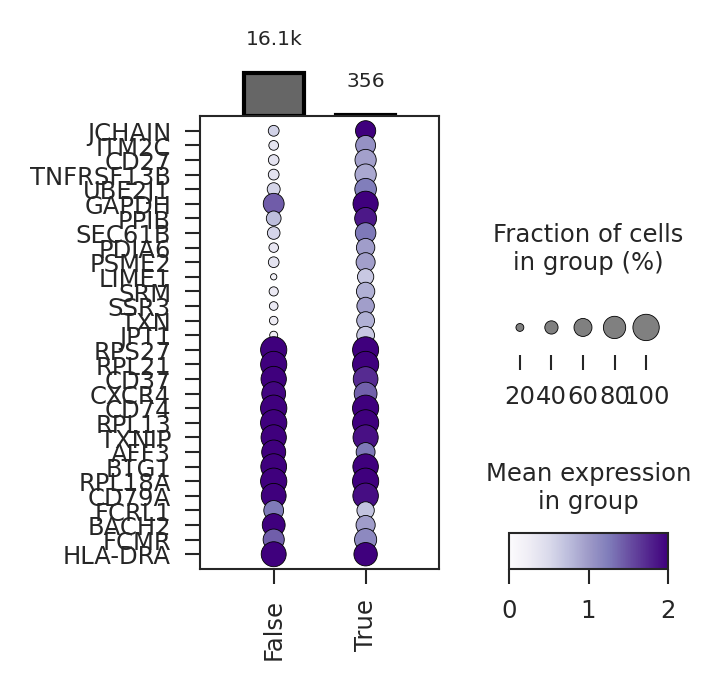

Saving figures...
Analysis complete. Figures saved in ../figures/MB_shared_GEX


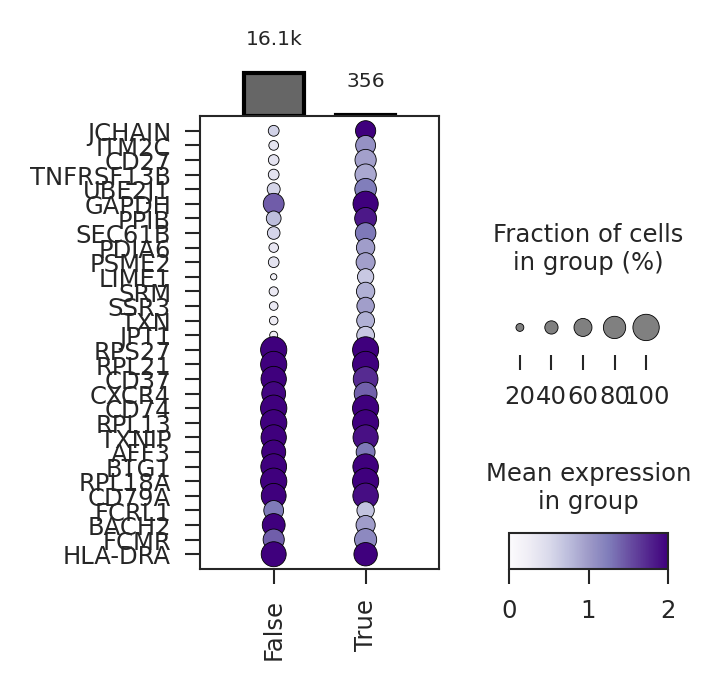

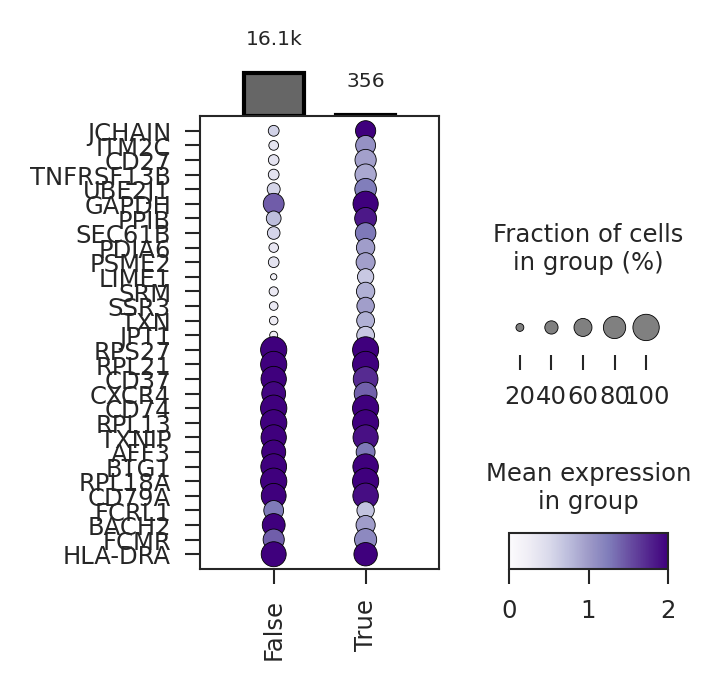

In [2]:
"""
Memory B Cell Sharing Analysis

This script performs analysis on shared memory B cells across different tissues.
It's designed to reproduce results from the paper [INSERT PAPER TITLE/LINK HERE].

Requirements:
- Python 3.7+
- Libraries: matplotlib, pandas, scanpy, seaborn, numpy, scikit-learn

Usage:
1. Ensure all required libraries are installed.
2. Set the correct paths for input data and output directory.
3. Run the script.

Author: [Your Name]
Date: [Current Date]
"""

import pathlib
from typing import List, Dict

import matplotlib as mpl
import pandas as pd
import scanpy as sc
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Configuration
DATA_DIR = pathlib.Path("../../data/annotation")
OUTPUT_DIR = pathlib.Path("../figures/MB_shared_GEX")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DOWNSAMPLE = True
H5AD_FILE = DATA_DIR / "all_sharing.h5ad.gz"
SHARED_DEFINITION = 'LN_SP'

TISSUE_COMBO_TO_COLUMN = {
    'LN_LN': 'shared_LN_LN',
    'LN_SP': 'shared_LN_SP',
    'LN_PB': 'shared_LN_PB',
    "BM_PB": 'shared_BM_PB',
    "SP_PB": 'shared_SP_PB',
    "SP_BM": 'shared_SP_BM',
    'LN_BM': 'shared_LN_BM',   
}

# Figure settings
SAVEFIG_ARGS = {
    "dpi": 300,
    "bbox_inches": "tight",
    "pad_inches": 0.1,
    "transparent": True,
}
OUTPUT_FORMATS = [".png", ".pdf"]

def setup_plotting():
    """Set up plotting parameters for consistent figure output."""
    mpl.rc("savefig", dpi=300)
    sc.set_figure_params(
        dpi_save=150,
        frameon=False,
        vector_friendly=True,
        fontsize=6,
        figsize=(3,3),
        format='pdf',
        transparent=True
    )
    sns.set_style("ticks")
    plt.style.use('../scripts/bursa.mplstyle')

def setup_pandas_display():
    """Configure pandas display settings for better output readability."""
    pd.set_option("display.max_rows", 50)
    pd.set_option("display.max_columns", 20)
    pd.set_option("display.width", 100)

def save_figure(fig: plt.Figure, name: str, output_suffix: str = ""):
    """Save the figure in multiple formats."""
    for output_format in OUTPUT_FORMATS:
        fig.savefig(OUTPUT_DIR / f"{name}{output_suffix}{output_format}", **SAVEFIG_ARGS)

def plot_custom_dotplot(ad: sc.AnnData, markers: List[str]):
    """
    Create a custom dot plot for gene expression analysis.
    
    Args:
    ad (sc.AnnData): Annotated data matrix.
    markers (List[str]): List of gene markers to plot.

    Returns:
    sc.pl.DotPlot: The created dot plot object.
    """
    dp = sc.pl.DotPlot(ad, markers, groupby='shared', figsize=(2, 2.25), vmax=2, vmin=0, expression_cutoff=0)
    dp.legend(width=0.8)
    dp.swap_axes()
    dp.add_totals(color='0.4', size=0.3).style(dot_edge_color='black', largest_dot=40, dot_edge_lw=0.2, cmap='Purples').show()

    axes = dp.get_axes()

    for child in axes['group_extra_ax'].get_children():
        if isinstance(child, mpl.text.Annotation):
            child.set(rotation=90, verticalalignment='bottom')

    axes['size_legend_ax'].set_title("")
    axes['size_legend_ax'].tick_params(axis='x', which='minor', length=0)
    axes['size_legend_ax'].tick_params(axis='x', labelsize=5)

    title = "% cells\nexpression > 0"
    axes['size_legend_ax'].text(0, 0.8, title, transform=axes['size_legend_ax'].transAxes, 
                                va='center', ha='left', fontsize=5)

    title = "Mean Expression\n($log_2$ UMI per 10K)"
    axes['color_legend_ax'].set_title("")
    axes['color_legend_ax'].text(0, 2.2, title, transform=axes['color_legend_ax'].transAxes, 
                                va='center', ha='left', fontsize=5)
    axes['color_legend_ax'].tick_params(axis='x', labelsize=5)

    for bar in axes['group_extra_ax'].patches:
        bar.set_edgecolor('none')

    return dp

def main():
    """Main function to run the analysis pipeline."""
    setup_plotting()
    setup_pandas_display()

    print("Loading data...")
    adata = sc.read_h5ad(H5AD_FILE)
    if DOWNSAMPLE:
        sc.pp.subsample(adata, n_obs=20000)
    print("Processing data...")
    adata.obs['shared'] = adata.obs[TISSUE_COMBO_TO_COLUMN[SHARED_DEFINITION]]
    print(f"{adata.obs.shared.value_counts().get(True, 0)} shared B cells")
    print(f"{adata.obs.shared.value_counts().get(False, 0)} not shared B cells")

    print("Performing differential expression analysis...")
    sc.tl.rank_genes_groups(adata, 'shared', method='wilcoxon')
    
    markers = sc.get.rank_genes_groups_df(adata, group='True')['names'][:15].tolist() + \
              sc.get.rank_genes_groups_df(adata, group='False')['names'][:15].tolist()

    print("Creating dot plot...")
    dp = plot_custom_dotplot(adata, markers)
    
    print("Saving figures...")
    save_figure(dp, "memory_b_cell_sharing_dotplot")

    print("Analysis complete. Figures saved in", OUTPUT_DIR)

if __name__ == "__main__":
    main()